In [1]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import dateutil.rrule as rrule
import matplotlib.dates as mdates
import matplotlib
import math
import statsmodels.api as sm
import re


import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
FILE_PATH = 'C:\\Users\\krzysztof.karabon\\OneDrive - GfK\\Desktop\\Prywata\\WroData\\20231119 Zanieczyszczenie powietrza'
DATA_PATH = f'{FILE_PATH}\\DATA\\'
OUT_PATH = f"{FILE_PATH}\\"

In [3]:
ZANIECZYSZCZENIE_LIST = ['NO2_1g', 'NOx_1g', 'PM10_1g', 'PM2.5_1g', 'SO2_1g']
STACJA_LIST = ['DsWrocBartni', 'DsWrocWybCon', 'DsWrocAlWisn']

In [4]:

DIC_NAMES = (
    {
        'DsWrocBartA': 'DsWrocBartni',
        'DsWrocWybCon-SO2-1g': 'DsWrocWybCon',
        'DsWrocKorzA': 'DsWrocWybCon',
        'DsWrocWisA': 'DsWrocAlWisn',
           })



# Wczytanie danych

## google mobility

In [5]:
# load all files
df_GOOGLE_MOBILITY_2020 = pd.read_csv(f'{DATA_PATH}\\Region_Mobility_Report_CSVs\\2020_PL_Region_Mobility_Report.csv')
df_GOOGLE_MOBILITY_2021 = pd.read_csv(f'{DATA_PATH}\\Region_Mobility_Report_CSVs\\2021_PL_Region_Mobility_Report.csv')
df_GOOGLE_MOBILITY_2022 = pd.read_csv(f'{DATA_PATH}\\Region_Mobility_Report_CSVs\\2022_PL_Region_Mobility_Report.csv')

# join files
df_GOOGLE_MOBILITY = pd.concat([df_GOOGLE_MOBILITY_2020, df_GOOGLE_MOBILITY_2021, df_GOOGLE_MOBILITY_2022])

# select only Wroclaw
df_GOOGLE_MOBILITY = df_GOOGLE_MOBILITY.loc[df_GOOGLE_MOBILITY['sub_region_2'] == 'Wrocław', :]
# fix format
df_GOOGLE_MOBILITY['Data'] = pd.to_datetime(df_GOOGLE_MOBILITY['date'], format='%Y-%m-%d')
# select only relevant columns
df_GOOGLE_MOBILITY = df_GOOGLE_MOBILITY.loc[:, ['Data', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']]

# fix column names
df_GOOGLE_MOBILITY.columns = ['Data', 'retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit_stations', 'workplaces', 'residential']

# order
df_GOOGLE_MOBILITY = df_GOOGLE_MOBILITY.sort_values(['Data']).reset_index(drop=True)

# show
df_GOOGLE_MOBILITY

Data  retail_and_recreation  grocery_and_pharmacy  parks  \
0   2020-02-15                    3.0                  -8.0   28.0   
1   2020-02-16                   10.0                 -34.0   15.0   
2   2020-02-17                    2.0                  -7.0   10.0   
3   2020-02-18                    4.0                  -9.0   15.0   
4   2020-02-19                    1.0                 -10.0   -1.0   
..         ...                    ...                   ...    ...   
969 2022-10-11                   -6.0                  13.0   52.0   
970 2022-10-12                   -5.0                  15.0   56.0   
971 2022-10-13                   -3.0                  17.0   68.0   
972 2022-10-14                   -4.0                  16.0   56.0   
973 2022-10-15                   -4.0                  10.0   35.0   

     transit_stations  workplaces  residential  
0                 4.0        -1.0         -3.0  
1                 4.0         1.0         -3.0  
2               -10.0       -12.0          0.0  
3               -11.0       -12.0          2.0  
4               -11.0       -12.0          1.0  
..                ...         ...          ...  
969              -2.0       -17.0          4.0  
970              -4.0       -17.0          3.0  
971              -1.0       -17.0          3.0  
972               1.0       -21.0          4.0  
973              19.0        11.0         -2.0  

[974 rows x 7 columns]

## zanieczyszczenia

### test on 1

In [6]:
rok = 2022
zanieczyszczenie = 'PM2.5_1g'
FILE_LIST = os.listdir(f'{DATA_PATH}\\{rok}\\')
# exclude tremporaty files
FILE_LIST = [x for x in FILE_LIST if not x.startswith('~$')]

# tylko te z zanieczyszczeniem
FILE_LIST = [x for x in FILE_LIST if re.sub(r'\.', '', zanieczyszczenie) in re.sub(r'\.', '', x)]
FILE_LIST

['2022_PM25_1g.xlsx']

In [7]:
rok = 2020
zan = pd.DataFrame()
zanieczyszczenie = 'NOx_1g'
stacja = 'DsWrocWybCon'

zan = pd.DataFrame()
col_list = []


FILE_LIST = os.listdir(f'{DATA_PATH}\\{rok}\\')
# exclude tremporaty files
FILE_LIST = [x for x in FILE_LIST if not x.startswith('~$')]

# tylko te z zanieczyszczeniem
FILE_LIST = [x for x in FILE_LIST if re.sub(r'\.', '', zanieczyszczenie) in re.sub(r'\.', '', x)]
print(f'{rok}: {FILE_LIST} - {stacja} - {zanieczyszczenie}')

if rok <= 2015:
    tmp_zan_raw = pd.read_excel(f'{DATA_PATH}\\{rok}\\{FILE_LIST[0]}')
    tmp_zan_raw = tmp_zan_raw.drop([0, 1, ])
else:
    tmp_zan_raw = pd.read_excel(f'{DATA_PATH}\\{rok}\\{FILE_LIST[0]}', skiprows=5)

# fix the column names
tmp_zan_raw = tmp_zan_raw.rename(columns = DIC_NAMES)
tmp_zan_raw.columns.values[0] = 'Data'
col_list = col_list + list(tmp_zan_raw.columns)

# select only relevant rows
col_stacja = [x for x in tmp_zan_raw.columns if str(x).startswith(stacja)]
tmp_zan = tmp_zan_raw.loc[:, ['Data'] + col_stacja]

if len(col_stacja) >= 1:
    # fix columns
    tmp_zan.columns.values[1] = 'Value'

    # fix format\
    tmp_zan['Value'] = tmp_zan['Value'].astype(str)
    tmp_zan['Value'] = tmp_zan['Value'].str.replace(',', '.')
    tmp_zan['Value'] = tmp_zan['Value'].astype(float)

# fix format\
tmp_zan['Data'] = pd.to_datetime(tmp_zan['Data'], format='%Y-%m-%d %H:%M:%S')
# add meta columns
tmp_zan['STACJA'] = stacja
tmp_zan['ZANIECZYSZCZENIE'] = zanieczyszczenie

tmp_zan['rok'] = tmp_zan['Data'].dt.year
tmp_zan['miesiac'] = tmp_zan['Data'].dt.month
tmp_zan['dzien'] = tmp_zan['Data'].dt.day

print(f'{rok}: {FILE_LIST} - {stacja} - {zanieczyszczenie} - {len(tmp_zan.loc[~tmp_zan["Value"].isna(), :].index)}')

tmp_zan

2020: ['2020_NOx_1g.xlsx'] - DsWrocWybCon - NOx_1g
2020: ['2020_NOx_1g.xlsx'] - DsWrocWybCon - NOx_1g - 8610


Data     Value        STACJA ZANIECZYSZCZENIE   rok  \
0    2020-01-01 01:00:00   6.45034  DsWrocWybCon           NOx_1g  2020   
1    2020-01-01 02:00:00   5.74397  DsWrocWybCon           NOx_1g  2020   
2    2020-01-01 03:00:00   5.89799  DsWrocWybCon           NOx_1g  2020   
3    2020-01-01 04:00:00   6.51780  DsWrocWybCon           NOx_1g  2020   
4    2020-01-01 05:00:00   5.62925  DsWrocWybCon           NOx_1g  2020   
...                  ...       ...           ...              ...   ...   
8779 2020-12-31 20:00:00  55.66470  DsWrocWybCon           NOx_1g  2020   
8780 2020-12-31 21:00:00  38.28730  DsWrocWybCon           NOx_1g  2020   
8781 2020-12-31 22:00:00  32.05630  DsWrocWybCon           NOx_1g  2020   
8782 2020-12-31 23:00:00  31.21660  DsWrocWybCon           NOx_1g  2020   
8783 2021-01-01 00:00:00  41.05540  DsWrocWybCon           NOx_1g  2021   

      miesiac  dzien  
0           1      1  
1           1      1  
2           1      1  
3           1      1  
4           1      1  
...       ...    ...  
8779       12     31  
8780       12     31  
8781       12     31  
8782       12     31  
8783        1      1  

[8784 rows x 7 columns]

### run all

In [8]:
df_ZANIECZYSZCZENIA = pd.DataFrame()
col_list = []
for zanieczyszczenie in ZANIECZYSZCZENIE_LIST:
    for stacja in STACJA_LIST:
        zan = pd.DataFrame()
        col_list = []
        for rok in range(2000,2023):

            try:
                FILE_LIST = os.listdir(f'{DATA_PATH}\\{rok}\\')
                # exclude tremporaty files
                FILE_LIST = [x for x in FILE_LIST if not x.startswith('~$')]

                # tylko te z zanieczyszczeniem
                FILE_LIST = [x for x in FILE_LIST if re.sub(r'\.', '', zanieczyszczenie) in re.sub(r'\.', '', x)]

                if rok <= 2015:
                    tmp_zan_raw = pd.read_excel(f'{DATA_PATH}\\{rok}\\{FILE_LIST[0]}')
                    tmp_zan_raw = tmp_zan_raw.drop([0, 1, ])
                else:
                    tmp_zan_raw = pd.read_excel(f'{DATA_PATH}\\{rok}\\{FILE_LIST[0]}', skiprows=5)

                # fix the column names
                tmp_zan_raw = tmp_zan_raw.rename(columns = DIC_NAMES)
                tmp_zan_raw.columns.values[0] = 'Data'
                col_list = col_list + list(tmp_zan_raw.columns)

                # select only relevant rows
                col_stacja = [x for x in tmp_zan_raw.columns if str(x).startswith(stacja)]
                tmp_zan = tmp_zan_raw.loc[:, ['Data'] + col_stacja]

                if len(col_stacja) >= 1:
                    # fix columns
                    tmp_zan.columns.values[1] = 'Value'

                    # fix format\
                    tmp_zan['Value'] = tmp_zan['Value'].astype(str)
                    tmp_zan['Value'] = tmp_zan['Value'].str.replace(',', '.')
                    tmp_zan['Value'] = tmp_zan['Value'].astype(float)

                # fix format\
                tmp_zan['Data'] = pd.to_datetime(tmp_zan['Data'], format='%Y-%m-%d %H:%M:%S')
                # add meta columns
                tmp_zan['STACJA'] = stacja
                tmp_zan['ZANIECZYSZCZENIE'] = zanieczyszczenie

                tmp_zan['rok'] = tmp_zan['Data'].dt.year
                tmp_zan['miesiac'] = tmp_zan['Data'].dt.month
                tmp_zan['dzien'] = tmp_zan['Data'].dt.day

                print(f'{rok}: {FILE_LIST} - {stacja} - {zanieczyszczenie} - {len(tmp_zan.loc[~tmp_zan["Value"].isna(), :].index)}')


                df_ZANIECZYSZCZENIA = pd.concat([df_ZANIECZYSZCZENIA, tmp_zan])
            except:
                print(f'ERROR: {rok}: {FILE_LIST} - {stacja} - {zanieczyszczenie}')


df_ZANIECZYSZCZENIA

ERROR: 2000: ['2000_NO2_1g.xlsx'] - DsWrocBartni - NO2_1g
ERROR: 2001: ['2001_NO2_1g.xlsx'] - DsWrocBartni - NO2_1g
ERROR: 2002: ['2002_NO2_1g.xlsx'] - DsWrocBartni - NO2_1g
ERROR: 2003: ['2003_NO2_1g.xlsx'] - DsWrocBartni - NO2_1g
ERROR: 2004: ['2004_NO2_1g.xlsx'] - DsWrocBartni - NO2_1g
2005: ['2005_NO2_1g.xlsx'] - DsWrocBartni - NO2_1g - 7193
2006: ['2006_NO2_1g.xlsx'] - DsWrocBartni - NO2_1g - 7569
2007: ['2007_NO2_1g.xlsx'] - DsWrocBartni - NO2_1g - 7983
2008: ['2008_NO2_1g.xlsx'] - DsWrocBartni - NO2_1g - 6860
2009: ['2009_NO2_1g.xlsx'] - DsWrocBartni - NO2_1g - 7053
2010: ['2010_NO2_1g.xlsx'] - DsWrocBartni - NO2_1g - 6666
2011: ['2011_NO2_1g.xlsx'] - DsWrocBartni - NO2_1g - 3593
ERROR: 2012: ['2012_NO2_1g.xlsx'] - DsWrocBartni - NO2_1g
ERROR: 2013: ['2013_NO2_1g.xlsx'] - DsWrocBartni - NO2_1g
2014: ['2014_NO2_1g.xlsx'] - DsWrocBartni - NO2_1g - 4704
2015: ['2015_NO2_1g.xlsx'] - DsWrocBartni - NO2_1g - 8550
2016: ['2016_NO2_1g.xlsx'] - DsWrocBartni - NO2_1g - 8700
2017: ['2017_N

Data  Value        STACJA ZANIECZYSZCZENIE   rok  miesiac  \
2    2005-01-01 01:00:00   28.0  DsWrocBartni           NO2_1g  2005        1   
3    2005-01-01 02:00:00   28.0  DsWrocBartni           NO2_1g  2005        1   
4    2005-01-01 03:00:00   25.0  DsWrocBartni           NO2_1g  2005        1   
5    2005-01-01 04:00:00   27.0  DsWrocBartni           NO2_1g  2005        1   
6    2005-01-01 05:00:00   28.0  DsWrocBartni           NO2_1g  2005        1   
...                  ...    ...           ...              ...   ...      ...   
8757 2014-12-31 20:00:00   10.0  DsWrocAlWisn           SO2_1g  2014       12   
8758 2014-12-31 21:00:00   10.0  DsWrocAlWisn           SO2_1g  2014       12   
8759 2014-12-31 22:00:00   10.0  DsWrocAlWisn           SO2_1g  2014       12   
8760 2014-12-31 23:00:00    9.0  DsWrocAlWisn           SO2_1g  2014       12   
8761 2015-01-01 00:00:00    4.0  DsWrocAlWisn           SO2_1g  2015        1   

      dzien  
2         1  
3         1  
4         1  
5         1  
6         1  
...     ...  
8757     31  
8758     31  
8759     31  
8760     31  
8761      1  

[1384894 rows x 7 columns]

In [9]:
fix = True
fix = False
if fix:
    df_ZANIECZYSZCZENIA = (
    pd.melt(
        df_ZANIECZYSZCZENIA,
        id_vars=['STACJA', 'ZANIECZYSZCZENIE', 'rok', 'miesiac', 'dzien', 'Data'],
        value_vars=['DsWrocBartni', 'DsWrocWybCon', 'DsWrocAlWisn'],
    )
    .dropna()
    .groupby(['STACJA', 'ZANIECZYSZCZENIE', 'rok', 'miesiac', 'dzien'])['Value']
    .mean()
    .reset_index()
    )

In [10]:
df_ZANIECZYSZCZENIA.sort_values(['STACJA', 'ZANIECZYSZCZENIE', 'rok']).groupby(['STACJA', 'ZANIECZYSZCZENIE', 'rok'])['Value'].count().reset_index()


STACJA ZANIECZYSZCZENIE   rok  Value
0    DsWrocAlWisn           NO2_1g  2005   7800
1    DsWrocAlWisn           NO2_1g  2006   8061
2    DsWrocAlWisn           NO2_1g  2007   8342
3    DsWrocAlWisn           NO2_1g  2008   8068
4    DsWrocAlWisn           NO2_1g  2009      1
..            ...              ...   ...    ...
172  DsWrocWybCon           SO2_1g  2019   8641
173  DsWrocWybCon           SO2_1g  2020   8555
174  DsWrocWybCon           SO2_1g  2021   8610
175  DsWrocWybCon           SO2_1g  2022   8639
176  DsWrocWybCon           SO2_1g  2023      1

[177 rows x 4 columns]

In [11]:
[x for x in list(np.unique(np.array(col_list))) if 'wroc' in x.lower()]

['DsWrocAlWisn', 'DsWrocGrun', 'DsWrocWybCon']

# połącz dane

In [12]:
df_ZANIECZYSZCZENIA = pd.merge(
    df_ZANIECZYSZCZENIA,
    df_GOOGLE_MOBILITY,
    how='left',
    left_on=['Data'],
    right_on=['Data'],
    )


# zapisz dane

In [13]:
df_ZANIECZYSZCZENIA.to_csv(f'{OUT_PATH}\\df_ZANIECZYSZCZENIA.csv', index=False)


In [ ]:
df_ZANIECZYSZCZENIA['Value'] = df_ZANIECZYSZCZENIA['Value'].astype(float)

In [27]:
pd.pivot_table(
    df_ZANIECZYSZCZENIA.loc[df_ZANIECZYSZCZENIA['ZANIECZYSZCZENIE'] == 'NO2_1g', :],
    index=['rok', 'miesiac', 'dzien'],
    columns=['STACJA'],
    aggfunc= np.nanmean,
    values = ['Value'],
    )


Value                          
STACJA             DsWrocAlWisn DsWrocBartni DsWrocWybCon
rok  miesiac dzien                                       
2005 1       1        38.272727    23.826087    18.409091
             2        35.608696    15.583333    10.956522
             3        46.043478    18.541667    13.565217
             4        45.130435    22.541667    15.260870
             5        51.857143    31.304348    23.571429
...                         ...          ...          ...
2022 12      28       44.633357     9.552878    16.101536
             29       36.315330     6.885106    16.461077
             30       48.376971    12.874801    22.070557
             31       23.287408     5.577525     8.563428
2023 1       1        25.533700     5.094070     6.420460

[6562 rows x 3 columns]

# Obróbka danych


In [14]:
df_ZANIECZYSZCZENIA_grouped_day = df_ZANIECZYSZCZENIA.groupby(['STACJA', 'ZANIECZYSZCZENIE', 'rok', 'miesiac', 'dzien']).agg({
    'Value': np.nanmean,
    'Data': 'count'
    }).reset_index().dropna()

# delete lonly days
df_ZANIECZYSZCZENIA_grouped_day = df_ZANIECZYSZCZENIA_grouped_day.loc[df_ZANIECZYSZCZENIA_grouped_day['Data'] > 1, :]
# drop date column
df_ZANIECZYSZCZENIA_grouped_day = df_ZANIECZYSZCZENIA_grouped_day.drop(columns=['Data'])

df_ZANIECZYSZCZENIA_grouped_day

STACJA ZANIECZYSZCZENIE   rok  miesiac  dzien      Value
0      DsWrocAlWisn           NO2_1g  2005        1      1  38.272727
1      DsWrocAlWisn           NO2_1g  2005        1      2  35.608696
2      DsWrocAlWisn           NO2_1g  2005        1      3  46.043478
3      DsWrocAlWisn           NO2_1g  2005        1      4  45.130435
4      DsWrocAlWisn           NO2_1g  2005        1      5  51.857143
...             ...              ...   ...      ...    ...        ...
57717  DsWrocWybCon           SO2_1g  2022       12     27   4.333161
57718  DsWrocWybCon           SO2_1g  2022       12     28   3.782240
57719  DsWrocWybCon           SO2_1g  2022       12     29   3.089300
57720  DsWrocWybCon           SO2_1g  2022       12     30   3.376417
57721  DsWrocWybCon           SO2_1g  2022       12     31   4.063927

[54249 rows x 6 columns]

In [15]:
df_ZANIECZYSZCZENIA_grouped_year = df_ZANIECZYSZCZENIA.groupby(['STACJA', 'ZANIECZYSZCZENIE', 'rok']).agg({
    'Value': np.nanmean,
    'Data': 'count'
    }).reset_index().dropna()


# delete lonly days
df_ZANIECZYSZCZENIA_grouped_year = df_ZANIECZYSZCZENIA_grouped_year.loc[df_ZANIECZYSZCZENIA_grouped_year['Data'] > 300 * 24, :]
# drop date column
df_ZANIECZYSZCZENIA_grouped_year = df_ZANIECZYSZCZENIA_grouped_year.drop(columns=['Data'])

# show
df_ZANIECZYSZCZENIA_grouped_year

STACJA ZANIECZYSZCZENIE   rok      Value
0    DsWrocAlWisn           NO2_1g  2005  67.547564
1    DsWrocAlWisn           NO2_1g  2006  69.138941
2    DsWrocAlWisn           NO2_1g  2007  60.893431
3    DsWrocAlWisn           NO2_1g  2008  63.500000
5    DsWrocAlWisn           NO2_1g  2010  69.748977
..            ...              ...   ...        ...
171  DsWrocWybCon           SO2_1g  2018   3.789507
172  DsWrocWybCon           SO2_1g  2019   4.036141
173  DsWrocWybCon           SO2_1g  2020   4.254955
174  DsWrocWybCon           SO2_1g  2021   5.240374
175  DsWrocWybCon           SO2_1g  2022   5.259954

[158 rows x 4 columns]

In [28]:
df_ZANIECZYSZCZENIA_grouped_day.to_csv(f'{OUT_PATH}\\df_ZANIECZYSZCZENIA_grouped_day.csv', index=False)
df_ZANIECZYSZCZENIA_grouped_year.to_csv(f'{OUT_PATH}\\df_ZANIECZYSZCZENIA_grouped_year.csv', index=False)


# Wizualizacja

## średnia 7-dzienna

DsWrocBartni - NO2_1g


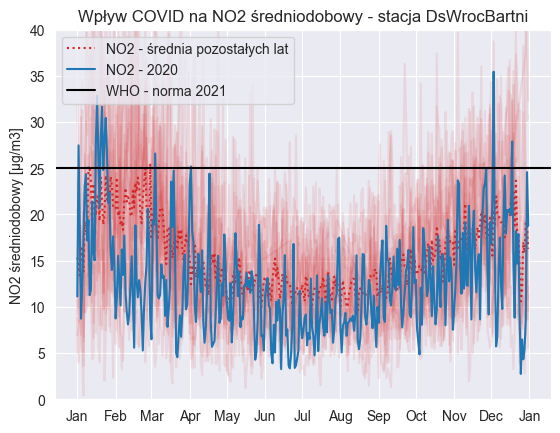

DsWrocBartni - NOx_1g


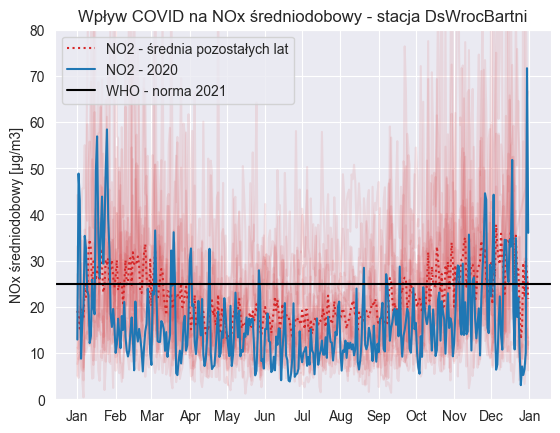

DsWrocBartni - PM10_1g
DsWrocBartni - PM2.5_1g
DsWrocBartni - SO2_1g
DsWrocWybCon - NO2_1g


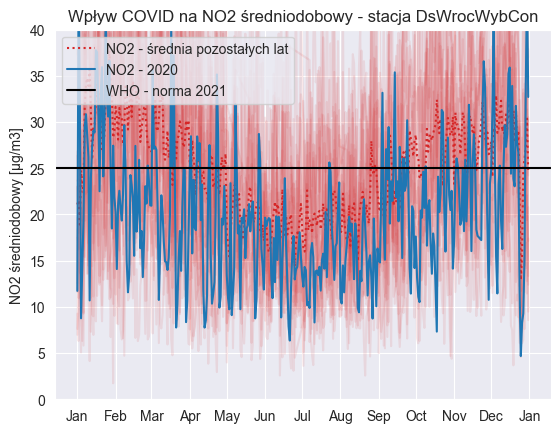

DsWrocWybCon - NOx_1g


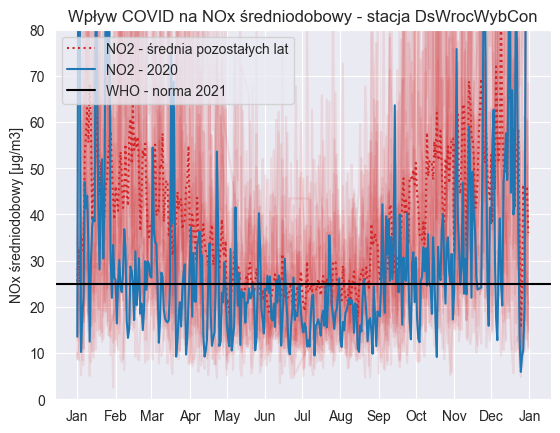

DsWrocWybCon - PM10_1g


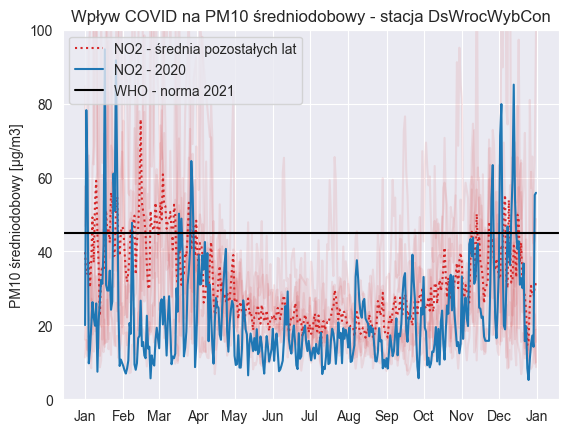

DsWrocWybCon - PM2.5_1g


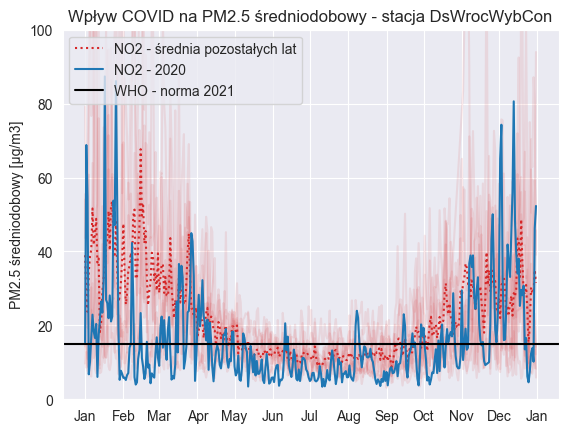

DsWrocWybCon - SO2_1g


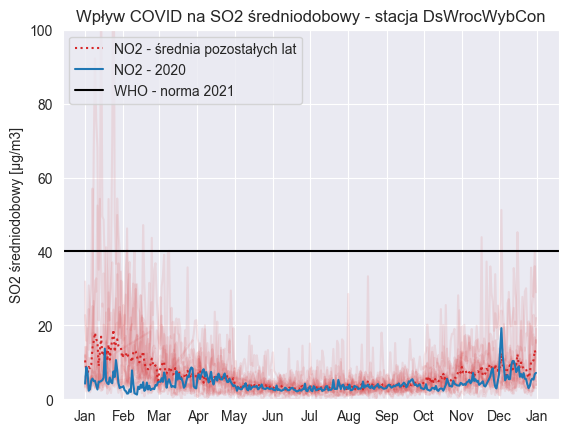

DsWrocAlWisn - NO2_1g


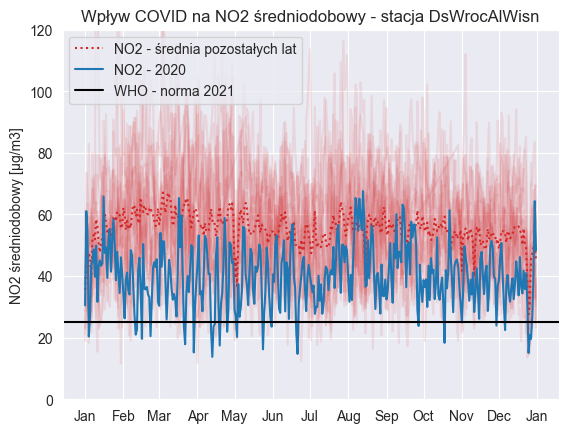

DsWrocAlWisn - NOx_1g


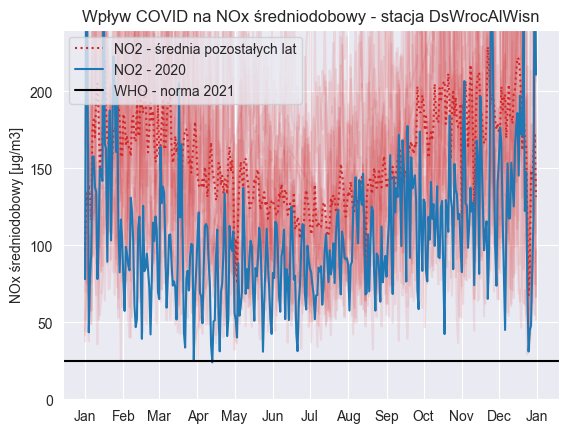

DsWrocAlWisn - PM10_1g
DsWrocAlWisn - PM2.5_1g


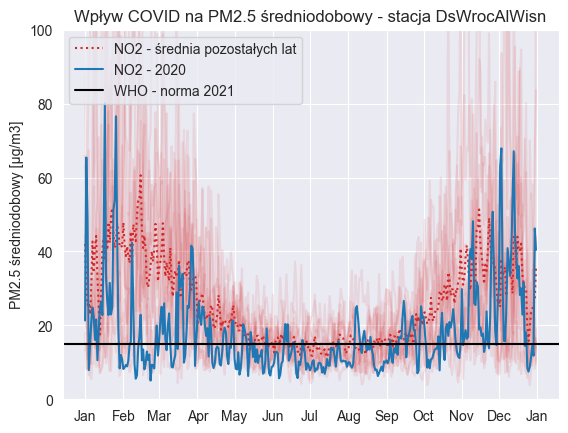

DsWrocAlWisn - SO2_1g


In [34]:
col_stacja = 'DsWrocBartni'
for stacja in STACJA_LIST:
    for wskaznik in ZANIECZYSZCZENIE_LIST:
        print(f'{stacja} - {wskaznik}')

        # select data
        t = df_ZANIECZYSZCZENIA_grouped_day.loc[
            (df_ZANIECZYSZCZENIA_grouped_day['STACJA'] == stacja) &
            (df_ZANIECZYSZCZENIA_grouped_day['ZANIECZYSZCZENIE'] == wskaznik), :]

        # usuń 2023 - tylko 1 ddzień
        t = t.loc[t['rok'] != 2023, :]


        t_2020 = t.loc[t['rok'] == 2020, :]
        t_other = t.loc[t['rok'] != 2020, :]

        if len(t_2020.index) == 0:
            continue

        # oblicz srednią:
        t_avg = (
            t_other
            .dropna(subset = ['Value'])
            .groupby(['miesiac', 'dzien'], dropna=False).agg({
                'Value': np.nanmean,
            }
            )
            .reset_index()
        )
        t_avg['miesiac'] = t_avg['miesiac'].astype(int)
        t_avg['dzien'] = t_avg['dzien'].astype(int)

        # add dates
        t_2020['Date'] = t_2020.apply(lambda x: datetime(2020, x['miesiac'], x['dzien']), axis=1)
        t_other['Date'] = t_other.apply(lambda x: datetime(2020, x['miesiac'], x['dzien']), axis=1)
        t_avg['Date'] = t_avg.apply(lambda x: datetime(int(2020), x['miesiac'].astype(int), x['dzien'].astype(int)), axis=1)

        # plot
        fig, ax1 = plt.subplots()
        color_1 = 'tab:red'
        color_2 = 'tab:blue'
        ax1.set_ylabel(f"{wskaznik.split('_')[0]} średniodobowy [µg/m3]")

        for r in t_other['rok'].unique():
            t_tmp = t_other.loc[t_other['rok'] == r, : ]
            ax1.plot(t_tmp['Date'], t_tmp['Value'],     c = color_1, alpha = 0.1)

        # add lines
        ax1.plot(t_avg['Date'],  t_avg['Value'] , c = color_1, linestyle = ':', label = 'NO2 - średnia pozostałych lat')
        ax1.plot(t_2020['Date'], t_2020['Value'], c = color_2, label = 'NO2 - 2020')

        # add WHO guidline
        ax1.axhline(y=DIC_NORMA[wskaznik], color='black', linestyle='-', label = 'WHO - norma 2021')
        # fix label
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax1.legend(loc = 'upper left')

        title = f"Wpływ COVID na {wskaznik.split('_')[0]} średniodobowy - stacja {stacja}"
        ax1.set_title(title)

        top = 100
        if wskaznik.split('_')[0] == 'NO2':
            top = 40
        elif wskaznik.split('_')[0] == 'NOx':
            top = 80
        elif wskaznik.split('_')[0] == 'PM10':
             plt.ylim(top=60)
        elif wskaznik.split('_')[0] == 'PM2.5':
             plt.ylim(top=60)
        elif wskaznik.split('_')[0] == 'SO2':
             plt.ylim(top=15)

        if (stacja == 'DsWrocAlWisn') & (wskaznik.split('_')[0] != 'PM2.5'):
            top = top * 3

        plt.ylim(top = top, bottom = 0)
        # save plot
        plt.savefig(f"{OUT_PATH}\\{title}.png")

        plt.show()
        plt.close()

## średnia 7-dzienna

DsWrocBartni - NO2_1g


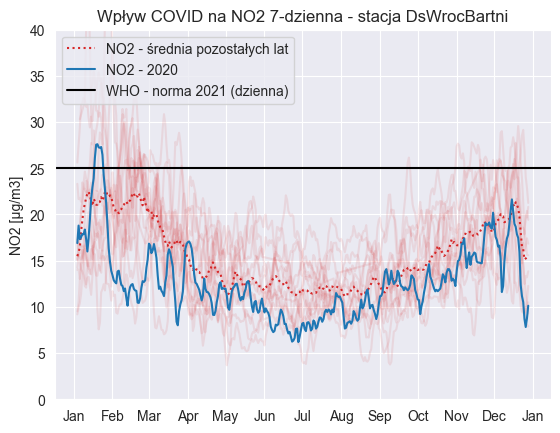

DsWrocBartni - NOx_1g


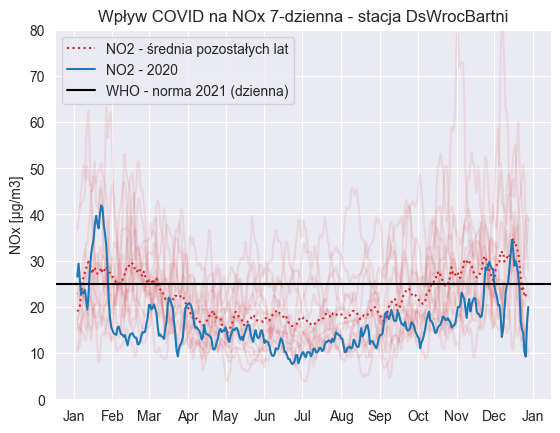

DsWrocBartni - PM10_1g
DsWrocBartni - PM2.5_1g
DsWrocBartni - SO2_1g
DsWrocWybCon - NO2_1g


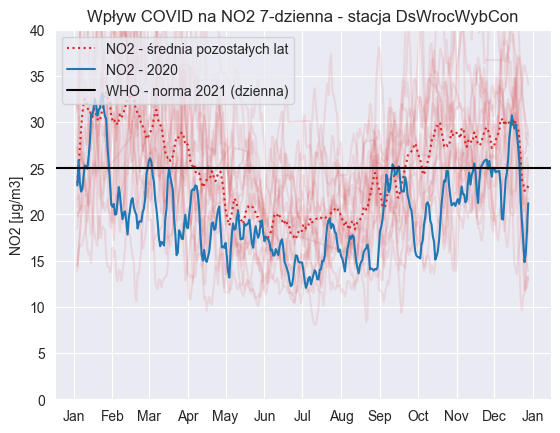

DsWrocWybCon - NOx_1g


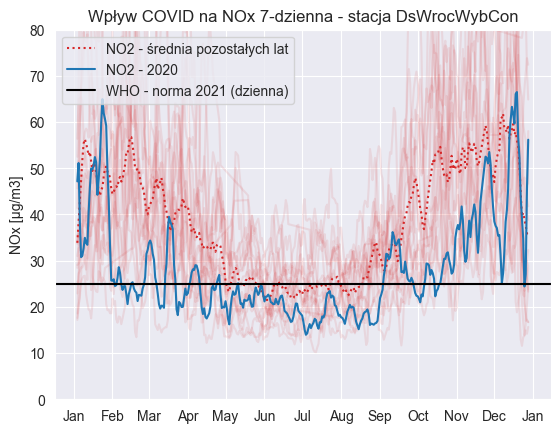

DsWrocWybCon - PM10_1g


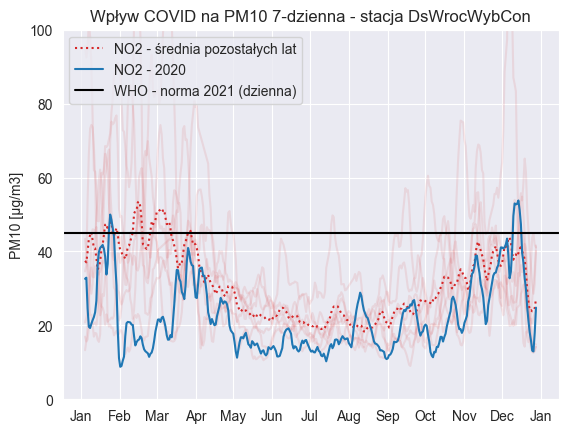

DsWrocWybCon - PM2.5_1g


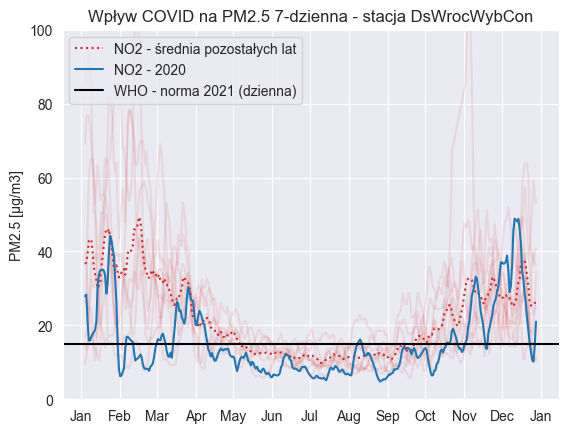

DsWrocWybCon - SO2_1g


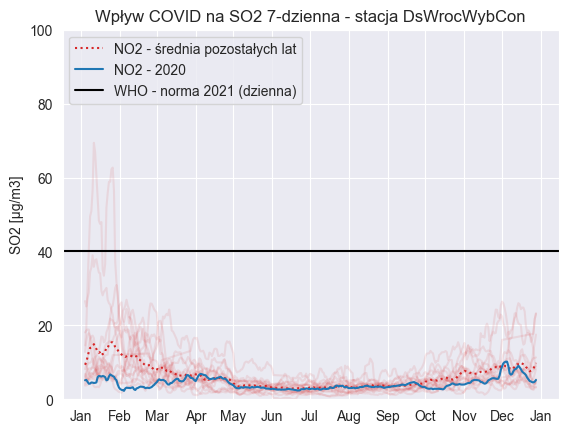

DsWrocAlWisn - NO2_1g


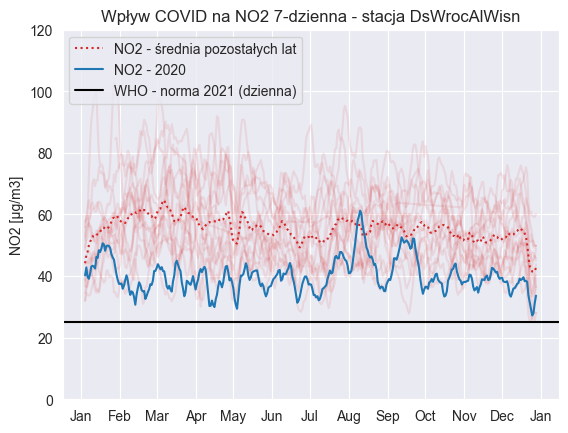

DsWrocAlWisn - NOx_1g


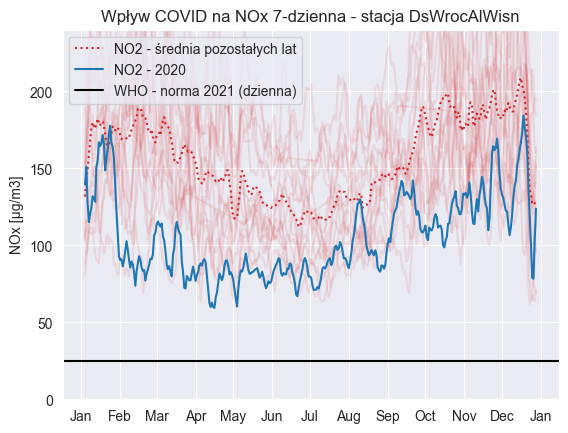

DsWrocAlWisn - PM10_1g
DsWrocAlWisn - PM2.5_1g


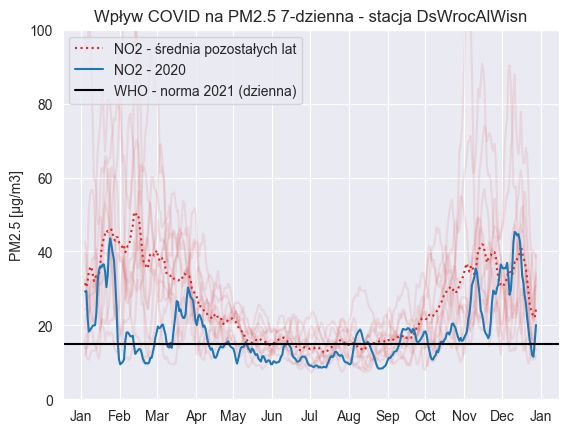

DsWrocAlWisn - SO2_1g


In [35]:
col_stacja = 'DsWrocBartni'
for stacja in STACJA_LIST:
    for wskaznik in ZANIECZYSZCZENIE_LIST:
        print(f'{stacja} - {wskaznik}')

        # select data
        t = df_ZANIECZYSZCZENIA_grouped_day.loc[
            (df_ZANIECZYSZCZENIA_grouped_day['STACJA'] == stacja) &
            (df_ZANIECZYSZCZENIA_grouped_day['ZANIECZYSZCZENIE'] == wskaznik), :]

        # usuń 2023 - tylko 1 ddzień
        t = t.loc[t['rok'] != 2023, :]


        t_2020 = t.loc[t['rok'] == 2020, :]
        t_other = t.loc[t['rok'] != 2020, :]

        if len(t_2020.index) == 0:
            continue

        # oblicz srednią:
        t_avg = (
            t_other
            .dropna(subset = ['Value'])
            .groupby(['miesiac', 'dzien'], dropna=False).agg({
                'Value': np.nanmean,
            }
            )
            .reset_index()
        )
        t_avg['miesiac'] = t_avg['miesiac'].astype(int)
        t_avg['dzien'] = t_avg['dzien'].astype(int)

        # add dates
        t_2020['Date'] = t_2020.apply(lambda x: datetime(2020, x['miesiac'], x['dzien']), axis=1)
        t_other['Date'] = t_other.apply(lambda x: datetime(2020, x['miesiac'], x['dzien']), axis=1)
        t_avg['Date'] = t_avg.apply(lambda x: datetime(int(2020), x['miesiac'].astype(int), x['dzien'].astype(int)), axis=1)

        # plot
        fig, ax1 = plt.subplots()
        color_1 = 'tab:red'
        color_2 = 'tab:blue'
        ax1.set_ylabel(f"{wskaznik.split('_')[0]} [µg/m3]")

        for r in t_other['rok'].unique():
            t_tmp = t_other.loc[t_other['rok'] == r, : ]
            ax1.plot(t_tmp['Date'], t_tmp['Value'].rolling(window=7, center=True).mean(),     c = color_1, alpha = 0.1)

        # add lines
        ax1.plot(t_avg['Date'],  t_avg['Value'].rolling(window=7, center=True).mean() , c = color_1, linestyle = ':', label = 'NO2 - średnia pozostałych lat')
        ax1.plot(t_2020['Date'], t_2020['Value'].rolling(window=7, center=True).mean(), c = color_2, label = 'NO2 - 2020')

        # add WHO guidline
        ax1.axhline(y=DIC_NORMA[wskaznik], color='black', linestyle='-', label = 'WHO - norma 2021 (dzienna)')
        # fix label
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax1.legend(loc = 'upper left')

        title = f"Wpływ COVID na {wskaznik.split('_')[0]} 7-dzienna - stacja {stacja}"
        ax1.set_title(title)

        top = 100
        if wskaznik.split('_')[0] == 'NO2':
            top = 40
        elif wskaznik.split('_')[0] == 'NOx':
            top = 80
        elif wskaznik.split('_')[0] == 'PM10':
             plt.ylim(top=60)
        elif wskaznik.split('_')[0] == 'PM2.5':
             plt.ylim(top=60)
        elif wskaznik.split('_')[0] == 'SO2':
             plt.ylim(top=15)

        if (stacja == 'DsWrocAlWisn') & (wskaznik.split('_')[0] != 'PM2.5'):
            top = top * 3

        plt.ylim(top = top, bottom = 0)
        # save plot
        plt.savefig(f"{OUT_PATH}\\{title}.png")

        plt.show()
        plt.close()

## średnia roczna

In [17]:
df_ZANIECZYSZCZENIA_grouped_year

STACJA ZANIECZYSZCZENIE   rok      Value
0    DsWrocAlWisn           NO2_1g  2005  67.547564
1    DsWrocAlWisn           NO2_1g  2006  69.138941
2    DsWrocAlWisn           NO2_1g  2007  60.893431
3    DsWrocAlWisn           NO2_1g  2008  63.500000
5    DsWrocAlWisn           NO2_1g  2010  69.748977
..            ...              ...   ...        ...
171  DsWrocWybCon           SO2_1g  2018   3.789507
172  DsWrocWybCon           SO2_1g  2019   4.036141
173  DsWrocWybCon           SO2_1g  2020   4.254955
174  DsWrocWybCon           SO2_1g  2021   5.240374
175  DsWrocWybCon           SO2_1g  2022   5.259954

[158 rows x 4 columns]

In [18]:
STACJA_LIST

['DsWrocBartni', 'DsWrocWybCon', 'DsWrocAlWisn']

DsWrocBartni - NO2_1g


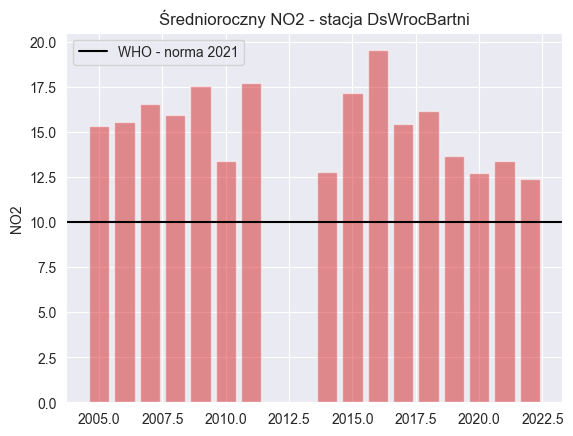

DsWrocBartni - NOx_1g


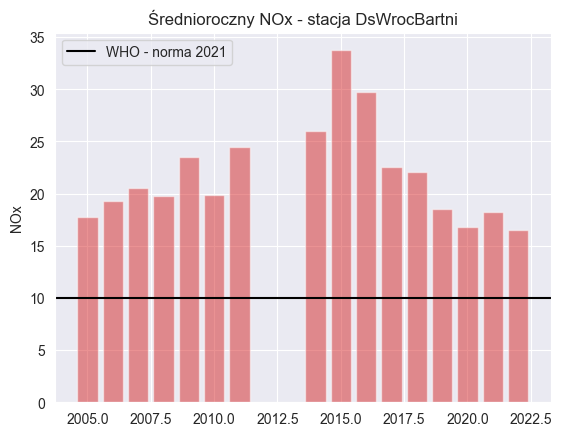

DsWrocBartni - PM10_1g


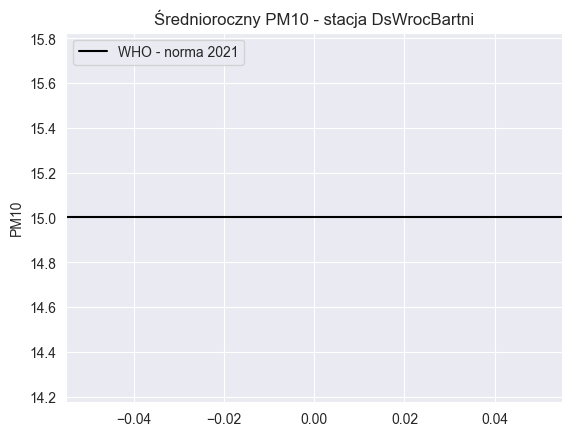

DsWrocBartni - PM2.5_1g


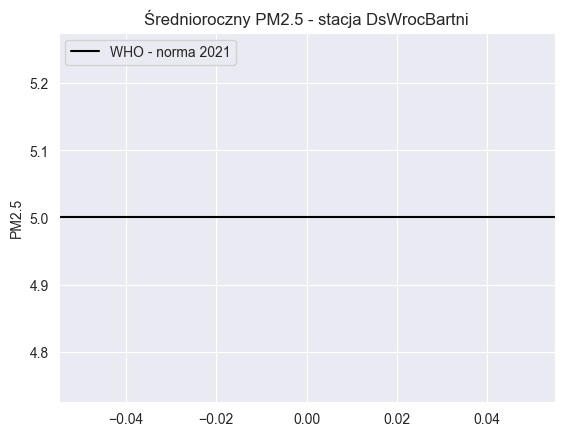

DsWrocBartni - SO2_1g


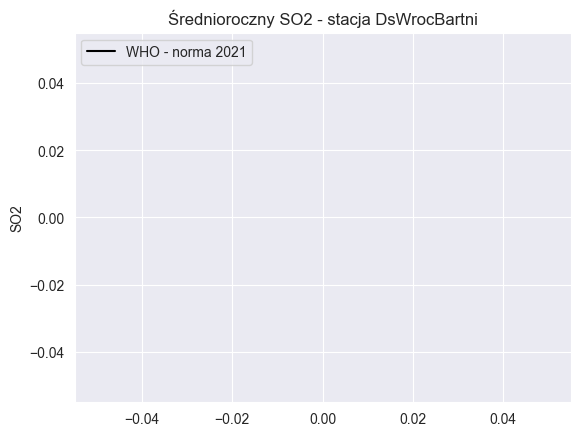

DsWrocWybCon - NO2_1g


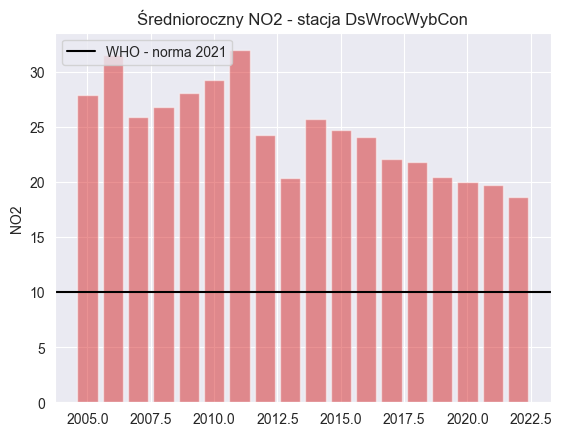

DsWrocWybCon - NOx_1g


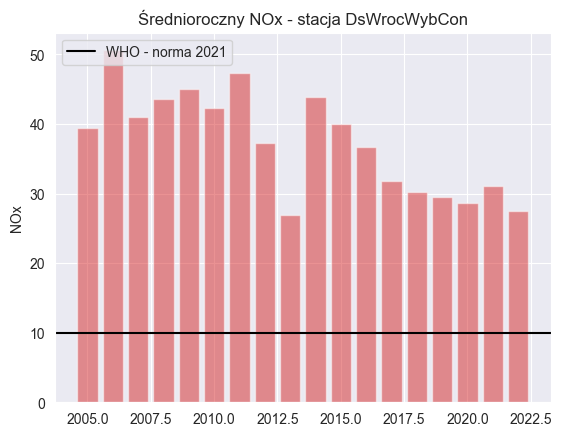

DsWrocWybCon - PM10_1g


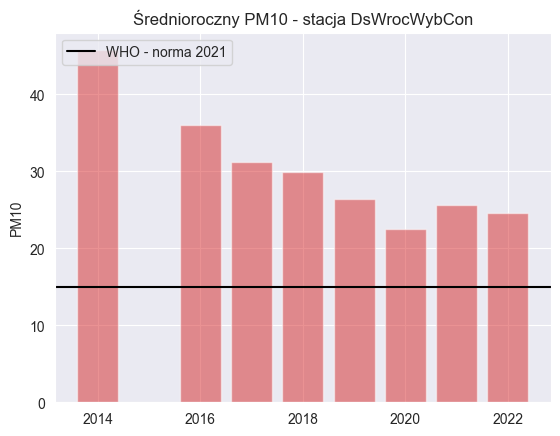

DsWrocWybCon - PM2.5_1g


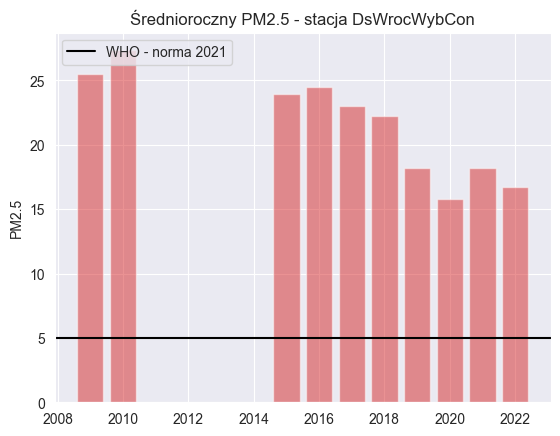

DsWrocWybCon - SO2_1g


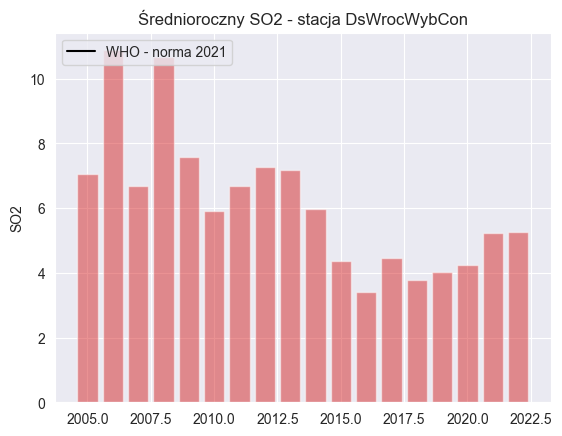

DsWrocAlWisn - NO2_1g


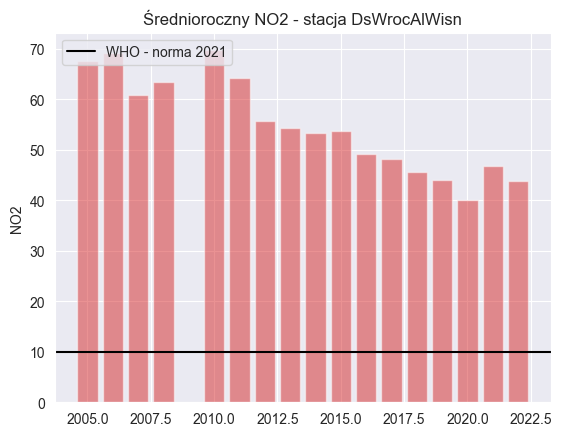

DsWrocAlWisn - NOx_1g


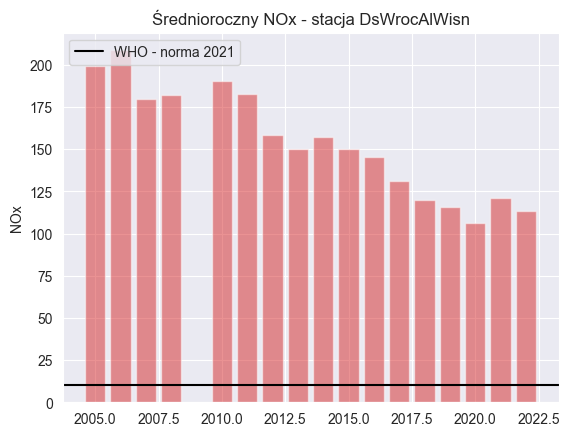

DsWrocAlWisn - PM10_1g


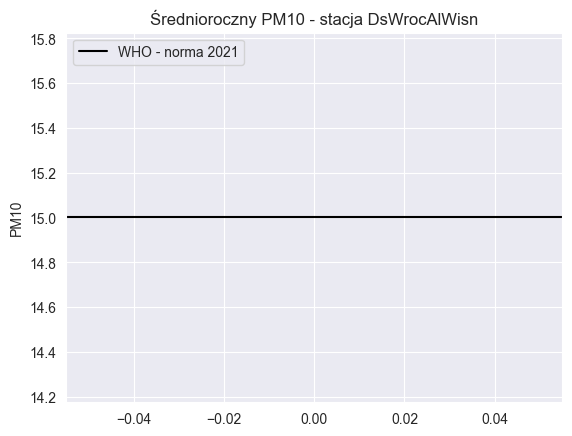

DsWrocAlWisn - PM2.5_1g


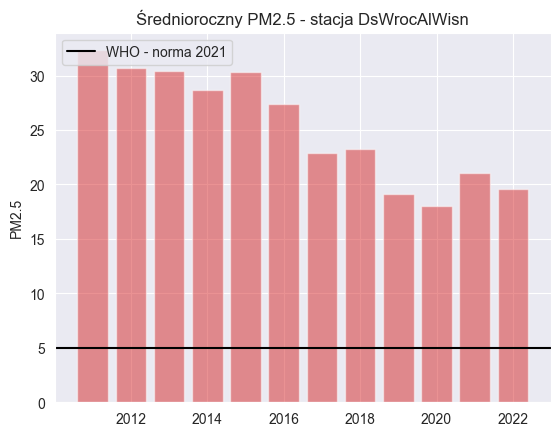

DsWrocAlWisn - SO2_1g


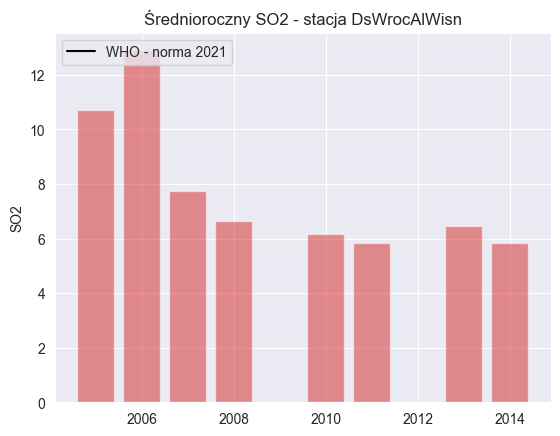

In [19]:

for stacja in STACJA_LIST:
    for wskaznik in ZANIECZYSZCZENIE_LIST:
        print(f'{stacja} - {wskaznik}')

        # select data
        t = df_ZANIECZYSZCZENIA_grouped_year.loc[
            (df_ZANIECZYSZCZENIA_grouped_year['STACJA'] == stacja) &
            (df_ZANIECZYSZCZENIA_grouped_year['ZANIECZYSZCZENIE'] == wskaznik), :]

        # usuń 2023 - tylko 1 ddzień
        t = t.loc[t['rok'] != 2023, :]

        t['Time'] = pd.to_datetime(t['rok'], format='%Y')

        # plot
        fig, ax1 = plt.subplots()
        color_1 = 'tab:red'
        color_2 = 'tab:blue'
        ax1.set_ylabel(wskaznik.split('_')[0])
        ax1.bar(t['rok'], t['Value'], color = color_1, alpha = 0.5)
        # add WHO guidline
        ax1.axhline(y=DIC_NORMA_roczna[wskaznik], color='black', linestyle='-', label = 'WHO - norma 2021')
        # fix label
        #ax1.xaxis.set_major_locator(mdates.YearLocator())
        #ax1.xaxis.set_major_formatter(mdates.DateFormatter("'%y"))
        #plt.xticks(np.arange(6, len(t), 12))
        # plt.xticks(rotation=45)

        #plt.xticks(labels=['2000', "'01", "'02", "'03", "'04", "'05", "'06", "'07", "'08", "'09", "'10", "'11", "'12", "'13", "'14", "'15", "'16", "'17", "'18", "'19", "'20", "'21", "2022"], ticks=np.arange(0, len(t), 12))

        ax1.legend(loc = 'upper left')

        title = f"Średnioroczny {wskaznik.split('_')[0]} - stacja {stacja}"
        ax1.set_title(title)

        # save plot
        plt.savefig(f"{OUT_PATH}\\{title}.png")
        plt.show()
        plt.close()


In [20]:
t

STACJA ZANIECZYSZCZENIE   rok      Value       Time
51  DsWrocAlWisn           SO2_1g  2005  10.703805 2005-01-01
52  DsWrocAlWisn           SO2_1g  2006  12.901129 2006-01-01
53  DsWrocAlWisn           SO2_1g  2007   7.732635 2007-01-01
54  DsWrocAlWisn           SO2_1g  2008   6.628799 2008-01-01
56  DsWrocAlWisn           SO2_1g  2010   6.153801 2010-01-01
57  DsWrocAlWisn           SO2_1g  2011   5.821925 2011-01-01
59  DsWrocAlWisn           SO2_1g  2013   6.458543 2013-01-01
60  DsWrocAlWisn           SO2_1g  2014   5.829541 2014-01-01

## liczba przekroczeń

DsWrocBartni - NO2_1g


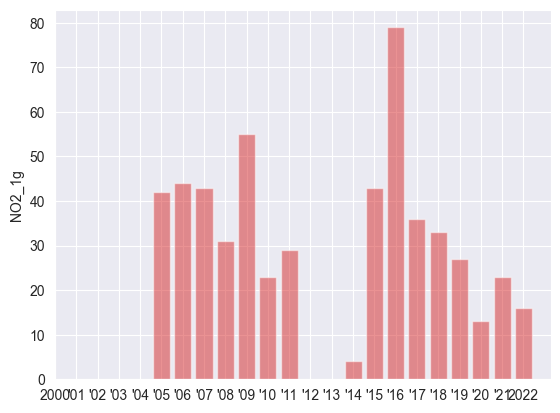

DsWrocBartni - NOx_1g


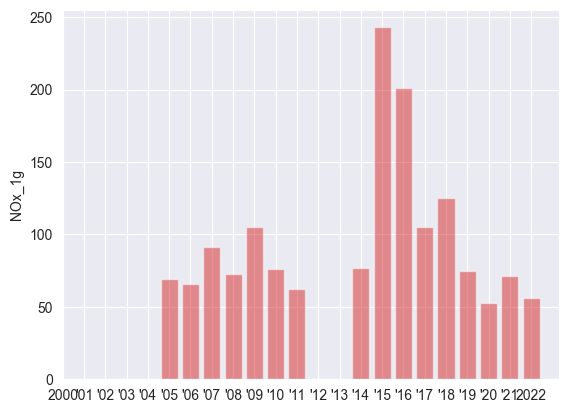

DsWrocBartni - PM10_1g


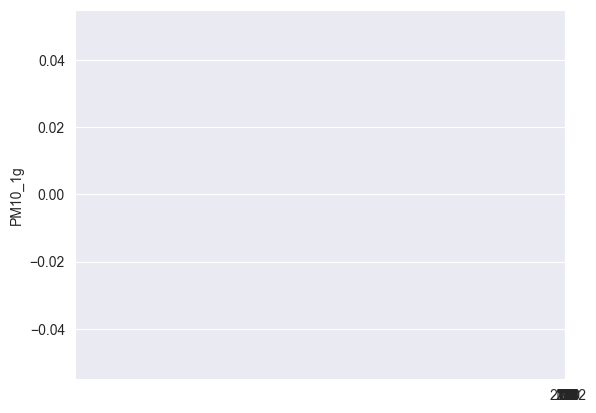

DsWrocBartni - PM2.5_1g


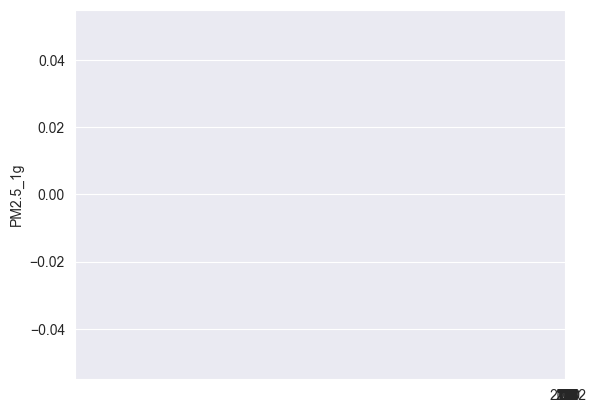

DsWrocBartni - SO2_1g


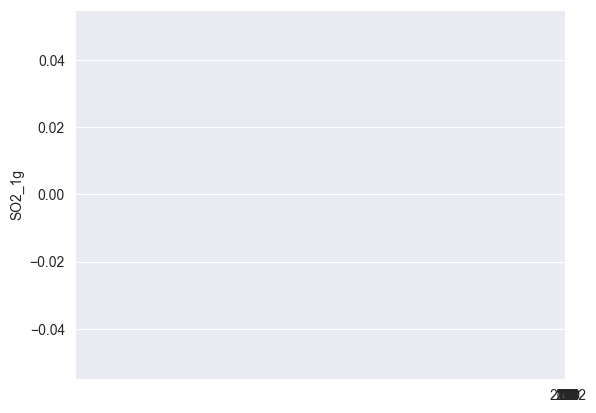

DsWrocWybCon - NO2_1g


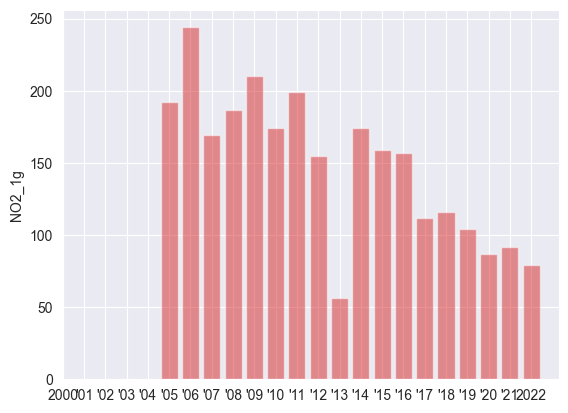

DsWrocWybCon - NOx_1g


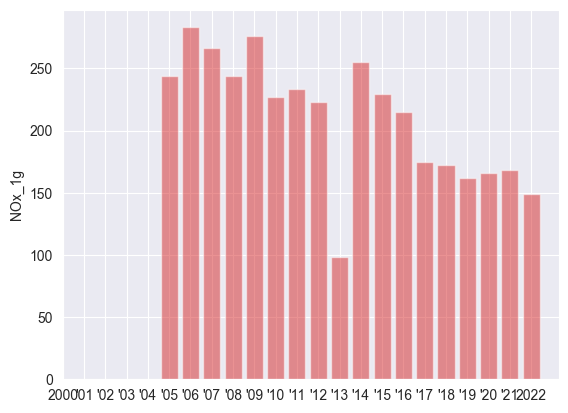

DsWrocWybCon - PM10_1g


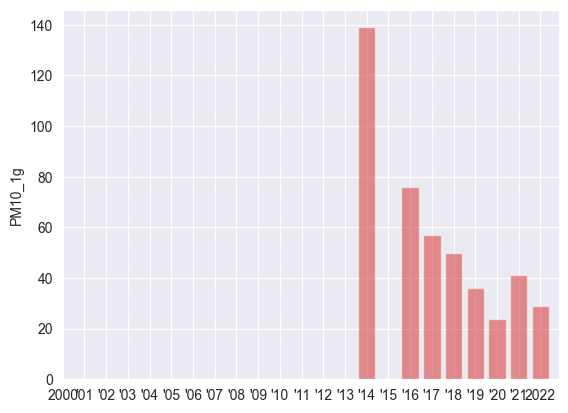

DsWrocWybCon - PM2.5_1g


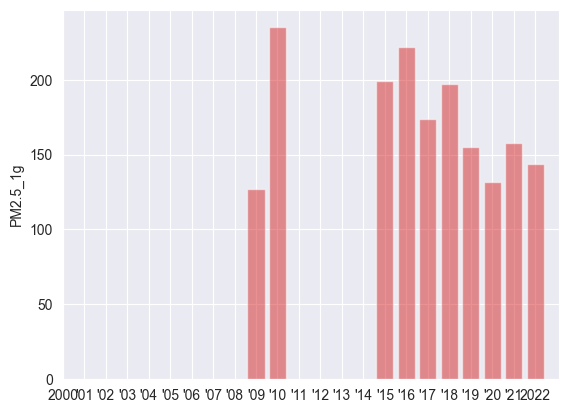

DsWrocWybCon - SO2_1g


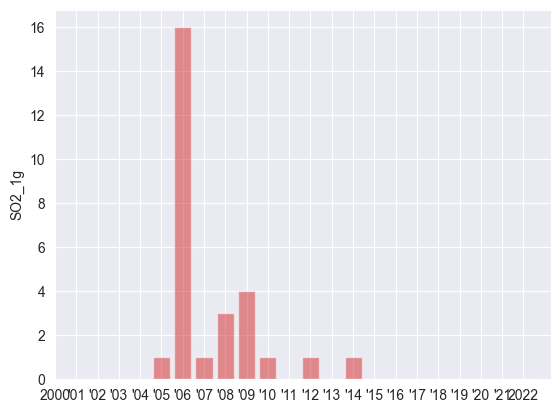

DsWrocAlWisn - NO2_1g


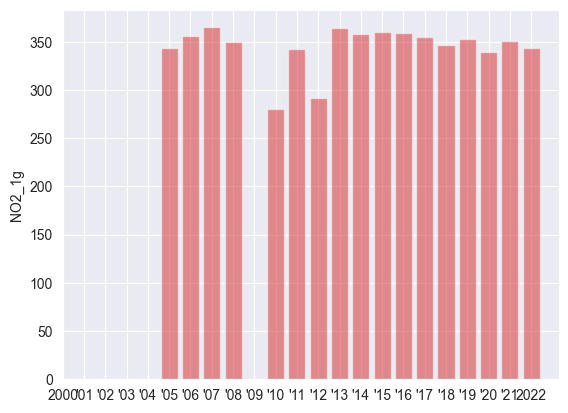

DsWrocAlWisn - NOx_1g


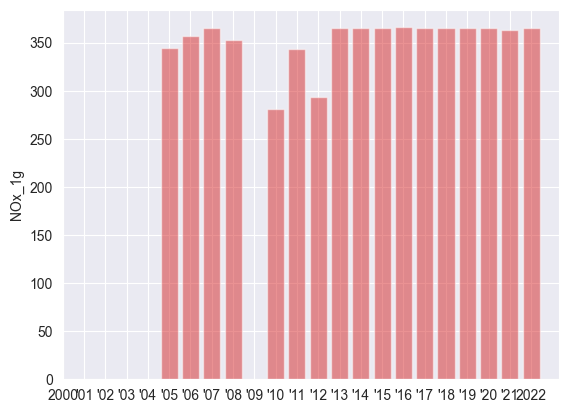

DsWrocAlWisn - PM10_1g


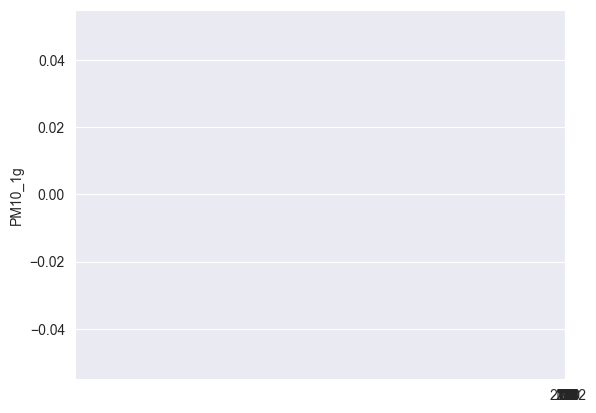

DsWrocAlWisn - PM2.5_1g


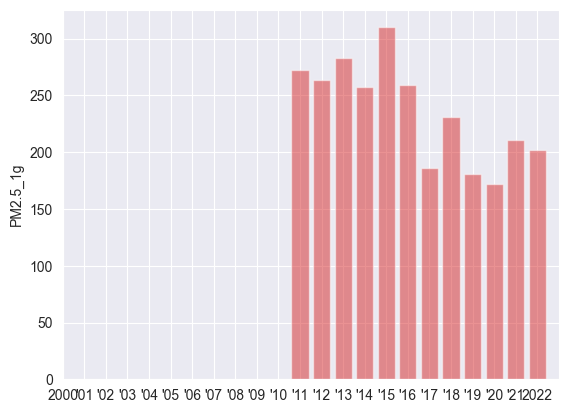

DsWrocAlWisn - SO2_1g


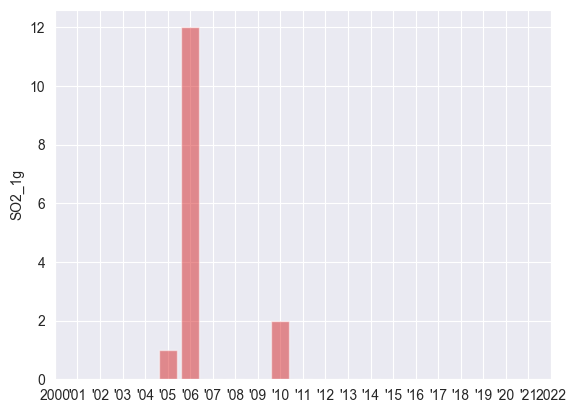

In [21]:

import matplotlib.ticker as mticker
for stacja in STACJA_LIST:
    for wskaznik in ZANIECZYSZCZENIE_LIST:
        print(f'{stacja} - {wskaznik}')

        # select data
        t = df_ZANIECZYSZCZENIA_grouped_day.loc[
            (df_ZANIECZYSZCZENIA_grouped_day['STACJA'] == stacja) &
            (df_ZANIECZYSZCZENIA_grouped_day['ZANIECZYSZCZENIE'] == wskaznik), :]

        # add column
        t['przekroczenie'] = t['Value'] > DIC_NORMA[wskaznik]

        # calulate nyumber of days with exceedance
        t = t.groupby(['rok',]).agg({
            'przekroczenie': np.sum,
            }).reset_index()

        # plot
        fig, ax1 = plt.subplots()
        color_1 = 'tab:red'
        color_2 = 'tab:blue'
        ax1.set_ylabel(wskaznik)

        ax1.bar(t['rok'], t['przekroczenie'], color = color_1, alpha = 0.5)

        # fix label
        plt.xticks(
            range(2000, 2023),
            ["2000", "'01", "'02", "'03", "'04", "'05", "'06", "'07", "'08", "'09", "'10", "'11", "'12", "'13", "'14", "'15", "'16", "'17", "'18", "'19", "'20", "'21", "2022"],
        )

        title = f"Liczna dni z przekroczną normą {wskaznik.split('_')[0]} - stacja {stacja}"
        # save plot
        #plt.savefig(f"{OUT_PATH}\\{title}.png")

        plt.show()
        plt.close()
